In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from flask import Flask, jsonify

In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import os
from scipy import stats
from datetime import datetime
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///../Resources/hawaii.sqlite')

inspector = inspect(engine)


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\willy\AppData\Local\Temp\ipykernel_38784\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
last_date = session.query(func.max(Measurement.date)).scalar()
last_date

'2017-08-23'

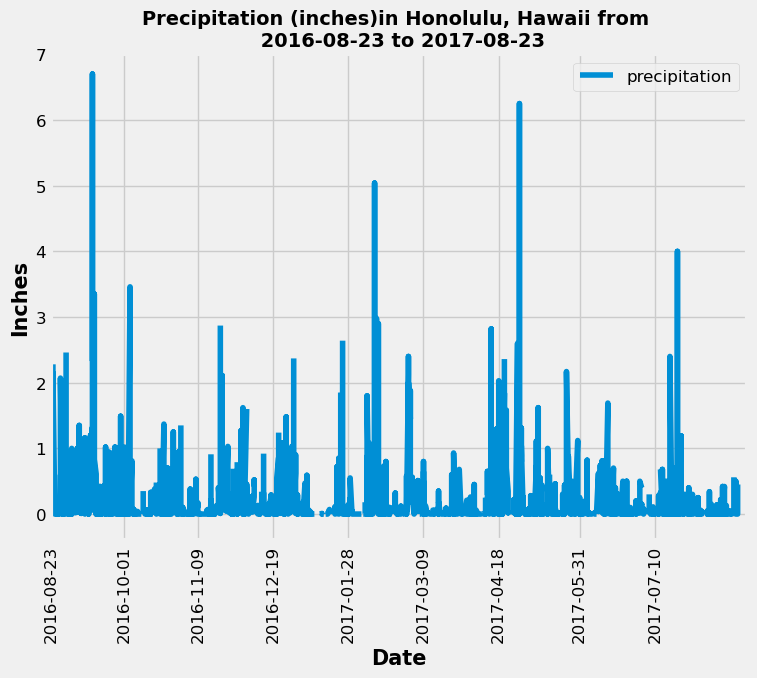

<Figure size 640x480 with 0 Axes>

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
inspector.get_table_names()
columns = inspector.get_columns('measurement')

session.query(Measurement.date, Measurement.prcp).all()

# Calculate the date one year from the last date in data set.
date_one_yr_ago_dt = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
query_date = date_one_yr_ago_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= '2016-08-23').all()
last_year

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(last_year)
last_year_df = last_year_df.set_index("date")
last_year_df.head()

# Sort the dataframe by date
sorted_df = last_year_df.sort_values(by = "date")
sorted_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
# Set plot and plot the chart
plt.figure(figsize=(8, 6))
plt.plot(sorted_df.index, sorted_df['prcp'])

# Add legned 
plt.legend(['precipitation'], loc="upper right",fontsize=12)
# set x location
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 

# Assign xticks
plt.xticks(xloc, rotation='vertical',fontsize=12)
# Set Labels & Title
plt.xlabel('Date', fontsize=15, fontweight = 'bold')
plt.ylabel("Inches",fontsize=15, fontweight = 'bold')
plt.title(f"Precipitation (inches)in Honolulu, Hawaii from \n {query_date} to {last_date}",fontsize=14, fontweight = 'bold')
plt.yticks(size=12)

# Asign xlim and ylim
plt.xlim(0,370)
plt.ylim(-0.4,7)


# Save Figure
plt.savefig("../Images/Precipitation_Plot.png")
# Show plot
plt.show()
plt.tight_layout()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
columns = inspector.get_columns('station')
session.query(Station.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = [Station.station, func.count(Measurement.station)]
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
most_active_stations=session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()
most_active_station_id = most_active_stations[0]
most_active_station_id

# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station_id).all()
most_active


[(54.0, 85.0, 71.66378066378067)]

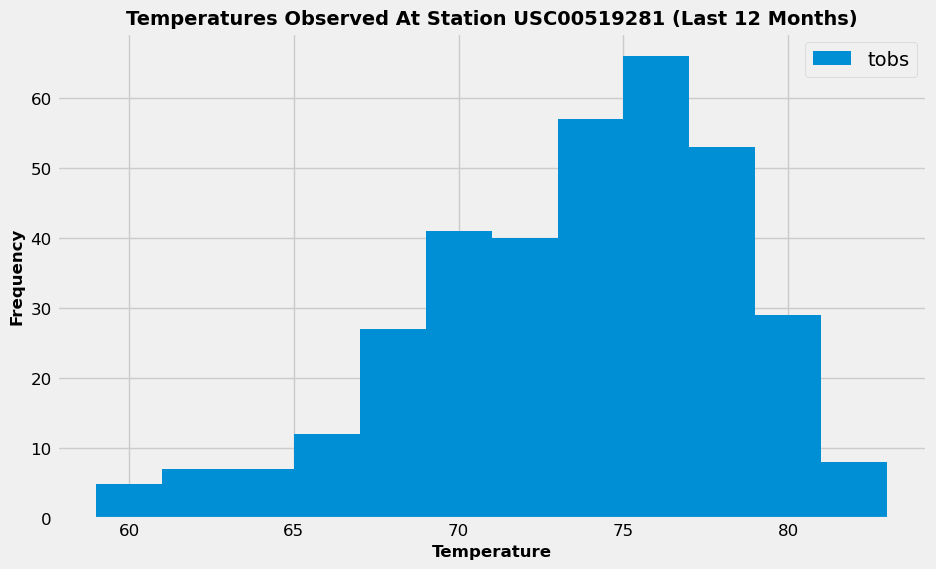

In [16]:
# Using the most active station id
session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(query_date,last_date),\
                   Measurement.station == 'USC00519281').all()

# Plot the results as a histogram
plt.figure(figsize=(10,6))
plt.hist(np.ravel(results), bins=12)
plt.title('Temperatures Observed At Station USC00519281 (Last 12 Months)',fontsize=14, fontweight = 'bold')
plt.xlabel('Temperature',fontsize=12, fontweight = 'bold')
plt.ylabel('Frequency',fontsize=12, fontweight = 'bold')
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=12)
plt.xticks(size=12)

# Save Figure
plt.savefig("../Images/Station_Plot.png")
plt.show()


# Close Session

In [17]:
# Close Session
session.close() 